In [1]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
#SEARCHING FOR P100
import os
import time
x=!nvidia-smi
count=0
for i in x:
    if "============" in i:
        count+=1
        break
    count+=1
if 'p100' in x[count].lower():
    print("found")
else:
    print(x[count])
    time.sleep(1)
    #os._exit(00)

|   0  GeForce GT 730     WDDM  | 00000000:01:00.0 N/A |                  N/A |


In [4]:
import tensorflow
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15188800701985086892
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15216245883552891295
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6388447010850134290
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [224,224]

train_path = 'train'
test_path = 'test'

In [6]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 2856 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


# **ResNet50**

In [8]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
for layer in resnet.layers:
  layer.trainable = False

In [10]:
x = Flatten()(resnet.output)

In [11]:
prediction = Dense(4, activation='softmax')(x)

In [12]:
model = Model(inputs = resnet.inputs, outputs = prediction)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=1, validation_steps=1,callbacks=[callback])

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 1.9952 - accuracy: 0.1875 - val_loss: 11.6471 - val_accuracy: 0.1875
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 13.5258 - accuracy: 0.1562 - val_loss: 5.4655 - val_accuracy: 0.3438
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 8.4551 - accuracy: 0.2500 - val_loss: 5.6468 - val_accuracy: 0.1875
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 4.8046 - accuracy: 0.3750 - val_loss: 4.2703 - val_accuracy: 0.1562


In [15]:
model.save('model1.h5')

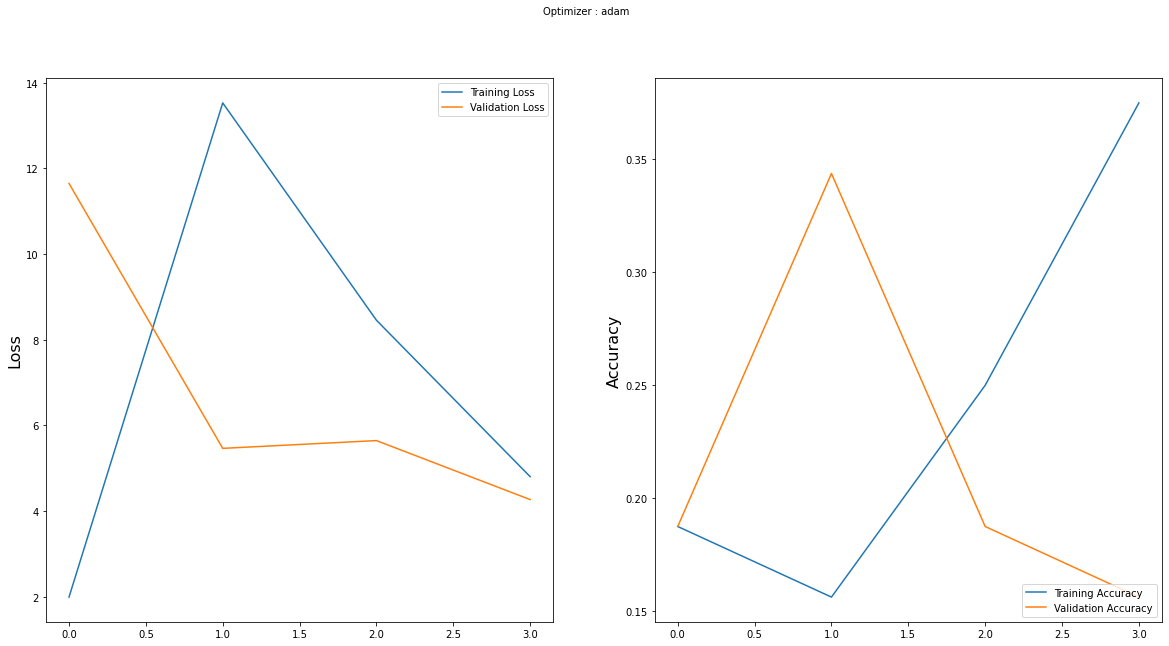

In [16]:
import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **For InceptionV3 with optimiser adam**

In [17]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)

In [19]:
predictions = Dense(4, activation='softmax')(x2)

# this is the model we will train
models = Model(inputs=base_model.input, outputs=predictions)
models.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
for layer in base_model.layers:
    layer.trainable = False


In [21]:
models.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = models.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

Epoch 1/20
90/90 [==============================] - 83s 925ms/step - loss: 0.6841 - accuracy: 0.7616 - val_loss: 0.5295 - val_accuracy: 0.8100
Epoch 2/20
90/90 [==============================] - 78s 865ms/step - loss: 0.3589 - accuracy: 0.8904 - val_loss: 0.4925 - val_accuracy: 0.8200
Epoch 3/20
90/90 [==============================] - 79s 873ms/step - loss: 0.2918 - accuracy: 0.9090 - val_loss: 0.4396 - val_accuracy: 0.8425
Epoch 4/20
90/90 [==============================] - 78s 867ms/step - loss: 0.2489 - accuracy: 0.9181 - val_loss: 0.4010 - val_accuracy: 0.8575
Epoch 5/20
90/90 [==============================] - 77s 859ms/step - loss: 0.2172 - accuracy: 0.9272 - val_loss: 0.3883 - val_accuracy: 0.8600
Epoch 6/20
90/90 [==============================] - 78s 868ms/step - loss: 0.1973 - accuracy: 0.9387 - val_loss: 0.3469 - val_accuracy: 0.8975
Epoch 7/20
90/90 [==============================] - 78s 865ms/step - loss: 0.1884 - accuracy: 0.9335 - val_loss: 0.4257 - val_accuracy: 0.8500

In [22]:
models.save('model2.h5')

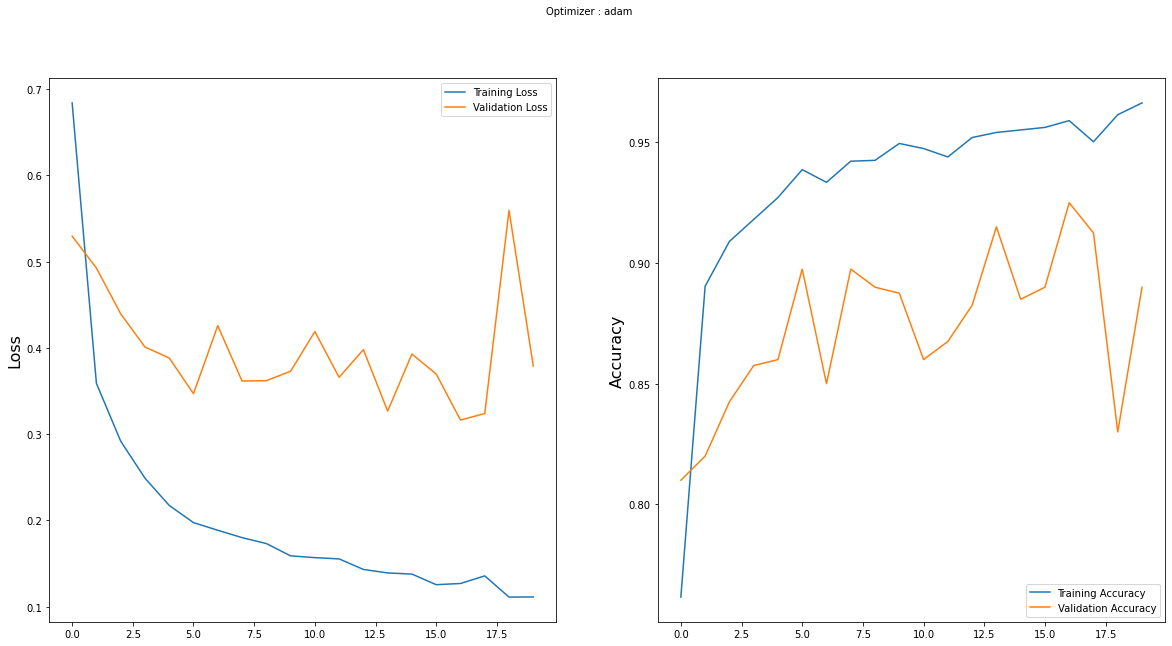

In [23]:
import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


# **INCEPTION RESNET V2**

In [24]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
inc=InceptionResNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [25]:
x3 = Flatten()(inc.output)
predictionss = Dense(4, activation='softmax')(x3)

In [26]:
modelss = Model(inputs = inc.inputs, outputs = predictionss)
modelss.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

block8_4_conv (Conv2D)          (None, 5, 5, 2080)   933920      block8_4_mixed[0][0]             
__________________________________________________________________________________________________
block8_4 (Lambda)               (None, 5, 5, 2080)   0           block8_3_ac[0][0]                
                                                                 block8_4_conv[0][0]              
__________________________________________________________________________________________________
block8_4_ac (Activation)        (None, 5, 5, 2080)   0           block8_4[0][0]                   
__________________________________________________________________________________________________
conv2d_274 (Conv2D)             (None, 5, 5, 192)    399360      block8_4_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_274 (BatchN (None, 5, 5, 192)    576         conv2d_274[0][0]                 
__________

In [27]:
modelss.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
r2 = modelss.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))
x=r2

Epoch 1/20
90/90 [==============================] - 940s 10s/step - loss: 0.9123 - accuracy: 0.8936 - val_loss: 231.7234 - val_accuracy: 0.5050
Epoch 2/20
90/90 [==============================] - 935s 10s/step - loss: 0.0452 - accuracy: 0.9856 - val_loss: 5.7316 - val_accuracy: 0.6175
Epoch 3/20
90/90 [==============================] - 934s 10s/step - loss: 0.3213 - accuracy: 0.9608 - val_loss: 14498125.0000 - val_accuracy: 0.2500
Epoch 4/20
90/90 [==============================] - 929s 10s/step - loss: 0.2494 - accuracy: 0.9692 - val_loss: 1694.2406 - val_accuracy: 0.2500
Epoch 5/20
90/90 [==============================] - 933s 10s/step - loss: 0.0625 - accuracy: 0.9786 - val_loss: 1.8928 - val_accuracy: 0.8325
Epoch 6/20
90/90 [==============================] - 943s 10s/step - loss: 0.5289 - accuracy: 0.9772 - val_loss: 2.2146 - val_accuracy: 0.6725
Epoch 7/20
90/90 [==============================] - 936s 10s/step - loss: 0.0286 - accuracy: 0.9898 - val_loss: 0.1409 - val_accuracy: 0

In [28]:
modelss.save('model3.h5')

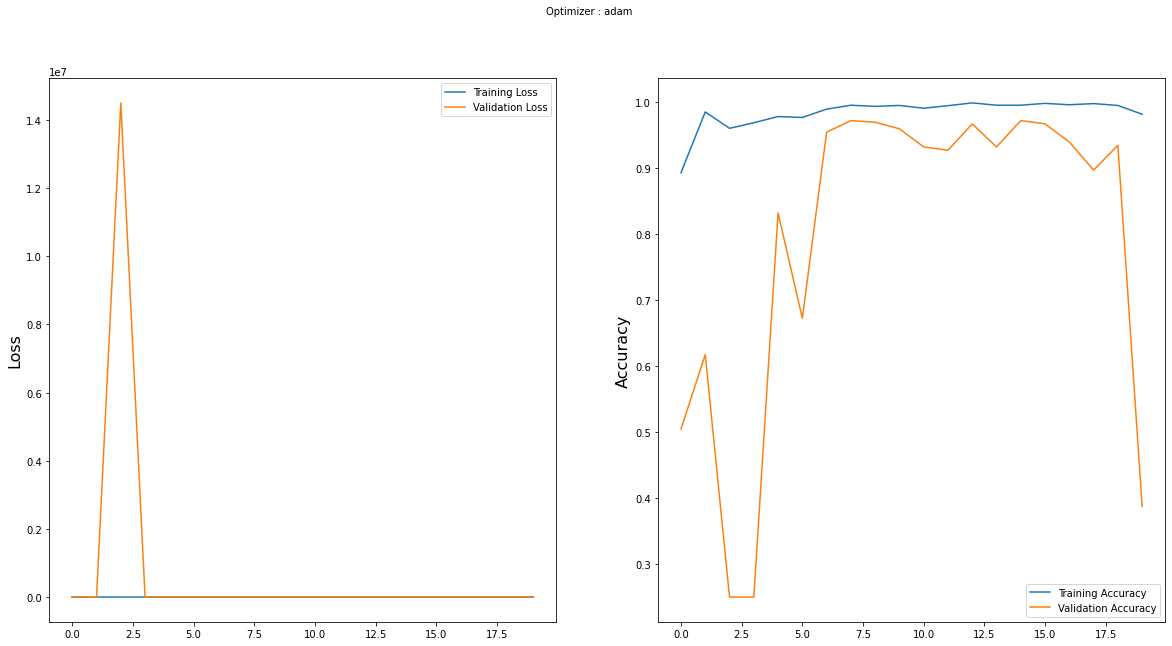

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **MobileNet**

In [30]:
from tensorflow.keras.applications import MobileNet, MobileNetV2
mob = MobileNet(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [31]:
x1= Flatten()(mob.output)
prediction1 = Dense(4, activation='softmax')(x1)
model12 = Model(inputs = mob.inputs, outputs = prediction1)
model12.summary()
model12.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [32]:
r1 = model12.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
90/90 [==============================] - 301s 3s/step - loss: 1.0028 - accuracy: 0.9156 - val_loss: 126.2303 - val_accuracy: 0.2825
Epoch 2/20
90/90 [==============================] - 302s 3s/step - loss: 0.2539 - accuracy: 0.9685 - val_loss: 19.4552 - val_accuracy: 0.6625
Epoch 3/20
90/90 [==============================] - 302s 3s/step - loss: 0.1775 - accuracy: 0.9716 - val_loss: 4.2740 - val_accuracy: 0.8475
Epoch 4/20
90/90 [==============================] - 301s 3s/step - loss: 0.0183 - accuracy: 0.9947 - val_loss: 1.6083 - val_accuracy: 0.9700
Epoch 5/20
90/90 [==============================] - 301s 3s/step - loss: 0.0119 - accuracy: 0.9975 - val_loss: 1.2456 - val_accuracy: 0.9425
Epoch 6/20
90/90 [==============================] - 301s 3s/step - loss: 0.0516 - accuracy: 0.9898 - val_loss: 1.2302 - val_accuracy: 0.8825
Epoch 7/20
90/90 [==============================] - 302s 3s/step - loss: 0.0639 - accuracy: 0.9881 - val_loss: 0.4151 - val_accuracy: 0.9100
Epoch 8/20

In [33]:
model12.save('model4.h5')

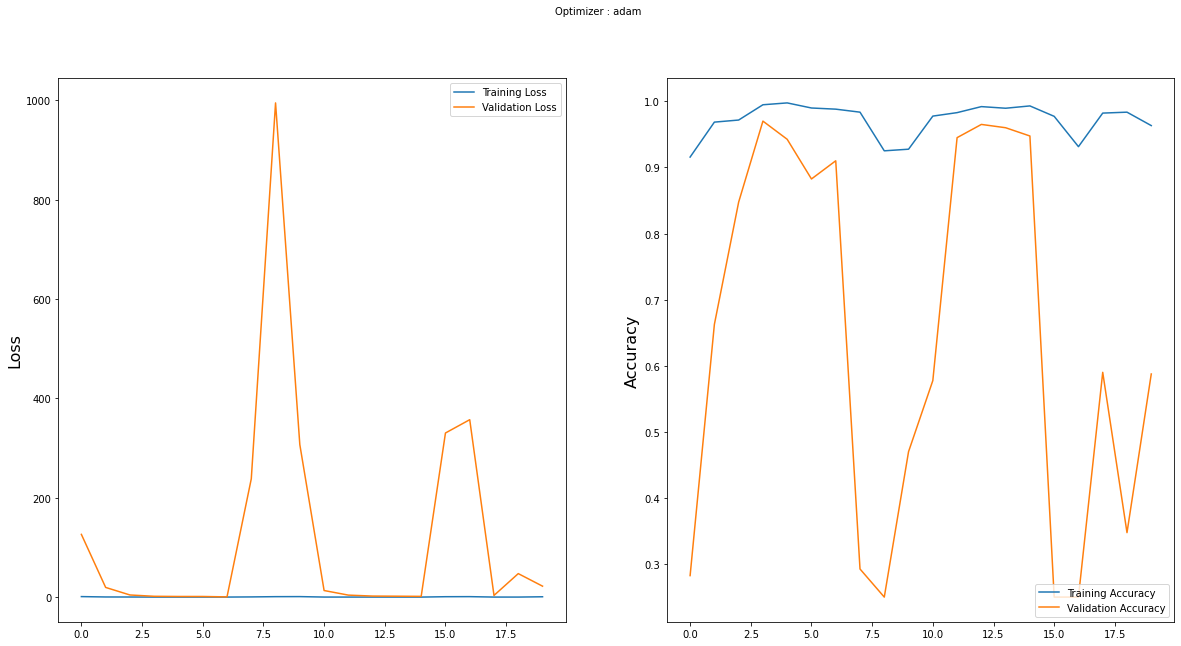

In [34]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **DenseNet121**

In [35]:
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, ResNet50V2,ResNet101V2,ResNet152V2

In [44]:
des121=DenseNet121(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [45]:
x1= Flatten()(des121.output)
prediction1 = Dense(4, activation='softmax')(x1)
model1 = Model(inputs = des121.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________

In [47]:
r1 = model1.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
90/90 [==============================] - 1137s 13s/step - loss: 0.0358 - accuracy: 0.9867 - val_loss: 2.9343 - val_accuracy: 0.6925
Epoch 2/20
90/90 [==============================] - 1140s 13s/step - loss: 0.0385 - accuracy: 0.9877 - val_loss: 6.5919 - val_accuracy: 0.6550
Epoch 3/20
90/90 [==============================] - 1141s 13s/step - loss: 0.7294 - accuracy: 0.9314 - val_loss: 1436.9603 - val_accuracy: 0.3200
Epoch 4/20
90/90 [==============================] - 1138s 13s/step - loss: 1.9150 - accuracy: 0.8890 - val_loss: 158782.4375 - val_accuracy: 0.2500
Epoch 5/20
90/90 [==============================] - 1141s 13s/step - loss: 1.0093 - accuracy: 0.8782 - val_loss: 7783.5830 - val_accuracy: 0.2575
Epoch 6/20
90/90 [==============================] - 1138s 13s/step - loss: 0.3204 - accuracy: 0.9475 - val_loss: 3.5938 - val_accuracy: 0.5000
Epoch 7/20
90/90 [==============================] - 1137s 13s/step - loss: 0.0862 - accuracy: 0.9688 - val_loss: 1.6035 - val_accur

KeyboardInterrupt: 

In [ ]:
model1.save('model_des.h5')

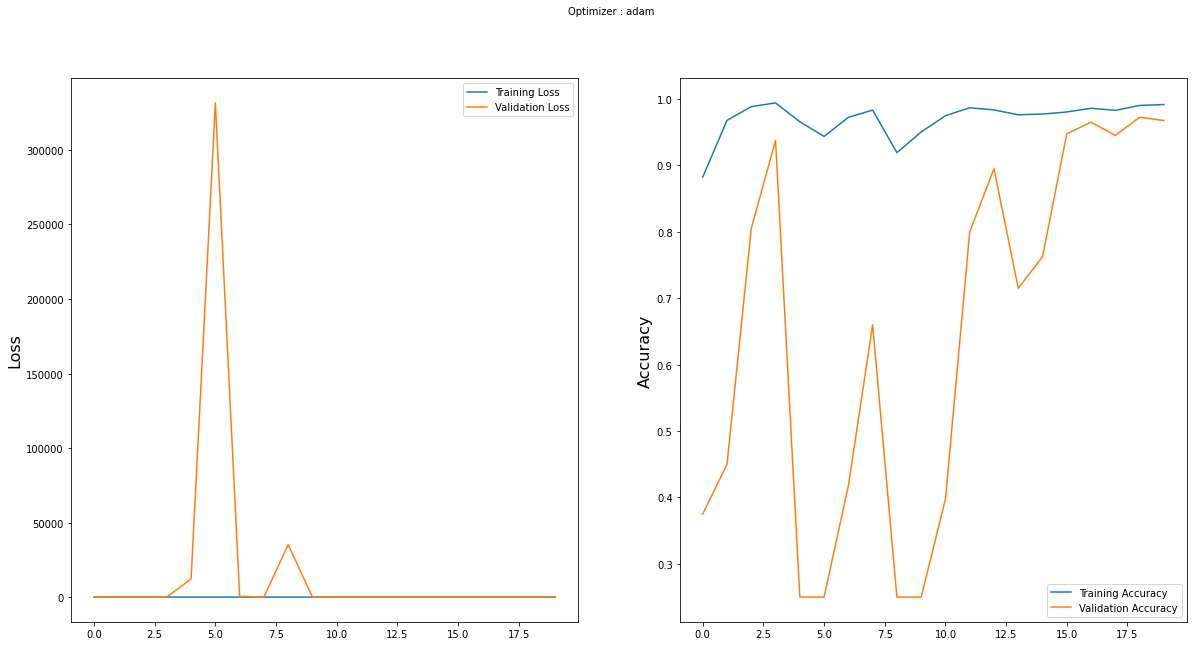

In [43]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **DenseNet169**

In [40]:
des169=DenseNet169(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

51879936/51877672 [==============================] - 5s 0us/step


In [41]:
x1= Flatten()(des169.output)
prediction1 = Dense(4, activation='softmax')(x1)
model1 = Model(inputs = des169.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________

conv5_block28_concat (Concatena (None, 7, 7, 1536)   0           conv5_block27_concat[0][0]       
                                                                 conv5_block28_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block29_0_bn (BatchNormal (None, 7, 7, 1536)   6144        conv5_block28_concat[0][0]       
__________________________________________________________________________________________________
conv5_block29_0_relu (Activatio (None, 7, 7, 1536)   0           conv5_block29_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block29_1_conv (Conv2D)   (None, 7, 7, 128)    196608      conv5_block29_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block29_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block29_1_conv[0][0]       
__________

In [42]:
r1 = model1.fit(train_set, validation_data=test_set, epochs=20, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/20
90/90 [==============================] - 1333s 15s/step - loss: 1.6913 - accuracy: 0.8775 - val_loss: 400824.8750 - val_accuracy: 0.2500
Epoch 2/20
90/90 [==============================] - 1346s 15s/step - loss: 0.2239 - accuracy: 0.9594 - val_loss: 5837.9546 - val_accuracy: 0.2500
Epoch 3/20
90/90 [==============================] - 1340s 15s/step - loss: 0.5926 - accuracy: 0.9401 - val_loss: 25.2064 - val_accuracy: 0.2500
Epoch 4/20
90/90 [==============================] - 1341s 15s/step - loss: 0.0979 - accuracy: 0.9790 - val_loss: 1.4047 - val_accuracy: 0.7750
Epoch 5/20
90/90 [==============================] - 1344s 15s/step - loss: 0.0909 - accuracy: 0.9804 - val_loss: 35.7559 - val_accuracy: 0.2500
Epoch 6/20
90/90 [==============================] - 1387s 15s/step - loss: 0.0796 - accuracy: 0.9793 - val_loss: 7.1057 - val_accuracy: 0.6600
Epoch 7/20
90/90 [==============================] - 1398s 16s/step - loss: 0.0327 - accuracy: 0.9898 - val_loss: 1.3329 - val_accura

KeyboardInterrupt: 

In [ ]:
model1.save('model6.h5')

In [ ]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()